##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
orig_df = pd.read_csv('../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [ ]:
df = pd.read_csv('../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [ ]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [ ]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [ ]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [ ]:
print(df.head(5))

# 'X' = Latitude of the location where crime was reported.
# 'Y' = Longitude of the location where crime was reported.
# 'Area_Command' = The police designation of the bureau of the operation.
# 'NIBRSOffenseCode' = The classification code for the crime committed.
# 'DayOfWeek' = A day in a week on which crime was committed in integer from 0 to 6.
# 'Time' = The time when crime was reported in terms of hours in interger from 0 to 23.
# 'VictimCount' = Total number of victims involved in the reported crime.

# Input Variables: These are the features used to predict the target variable. In our case, input features are 'X', 'Y', 'Area_Command', 'NIBRSOffenseCode','DayOfWeek', 'Time'.
# Target Variable: This is what we want to predict. In our case, target variable is 'VictimCount'.

# The range of values for 'X': -116.0 to -114.6255705
# The range of values for 'Y': 35.0684190000001 to 37.0000000000001
# The range of values for 'Area_Command': 0 to 11
# The range of values for 'NIBRSOffenseCode': 0 to 2
# The range of values for 'DayOfWeek': 0 to 6
# The range of values for 'Time': 0 to 23
# The range of values for 'VictimCount': 0 to 6

# The features latitude and longitude will be required to be normalized.
# Step 1: Calculate the minimum values

min_latitude = min(df['X'])
min_longitude = min(df['Y'])

df['X'] = df['X'] - min_latitude
df['Y'] = df['Y'] - min_longitude

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [200]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

X = torch.tensor(df.drop('VictimCount', axis = 1).values.astype(np.float32))
y = torch.tensor(df['VictimCount'].values.astype(np.float32))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
class DataSet(Dataset):

    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data

    def __getitem__(self, index):
        return self.X_data[index], self.Y_data[index]

    def __len__ (self):
        return len(self.X_data)

training_dataset = DataSet(X_train,y_train)
train_loader = DataLoader(dataset = training_dataset, batch_size = 40, shuffle = False)

test_dataset = DataSet(X_test,y_test)
test_loader = DataLoader(dataset = test_dataset, batch_size = 40, shuffle = False)

for batches,data in enumerate(train_loader):
    x,y = data
    #print("INP: ",x,"TARG : ",y)
    print("Batch: ", batches ," X: ", x.shape," Y: ", y.shape)
    print(x[3,:], "Size: ",x[3,:].shape)
    break

Batch:  0  X:  torch.Size([40, 6])  Y:  torch.Size([40])
tensor([ 0.0000,  1.9316, 11.0000,  1.0000,  2.0000, 12.0000]) Size:  torch.Size([6])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [206]:
# Defining the loss function MSE.
criterion = torch.nn.MSELoss()

# Since, we're predicting a single real number (number of crime victims), the size of the predicted output should be 1.

# For a basic regression task, a feedforward neural network should work. We can start with a simple architecture, with 10 hidden layers. The exact number of layers and units will depend on the complexity of your data.
class Neural_Network(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Neural_Network, self).__init__()
        self.layer_1 = torch.nn.Linear(input_size, 20) # layer1 input variables : 6 , output : 20
        self.layer_2 = torch.nn.Linear(20,10) # layer1 input variables : 20 , output : 10
        self.layer_3 = torch.nn.Linear(10,5) # layer1 input variables : 10 , output : 5
        self.layer_4 = torch.nn.Linear(5,output_size) # layer1 input variables : 5 , output : 1
        self.activation_function = torch.nn.ReLU()

    def forward(self, x):
        a_1 = self.layer_1(x) # linear output of layer1
        h_1 = self.activation_function(a_1) # output from layer 1 after applying activation function
        a_2 = self.layer_2(h_1) # linear output of layer2
        h_2 = self.activation_function(a_2) # output from layer 2 after applying activation function
        a_3 = self.layer_3(h_2) # linear output of layer3
        h_3 = self.activation_function(a_3) # # output from layer 3 after applying activation function
        a_4 = self.layer_4(h_3)
        pred_output =  a_4 # output from layer 3 after activation
        return pred_output

input_size = 6  # Adjust this based on the number of features
output_size = 1  # Predicting a single value
model = Neural_Network(input_size, output_size)

# I have used Adam optimizer. I can adjust the learning rate based on the behavior of training process.
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# This loop will go through batches of data, perform forward and backward passes, and update the weights of the network. Additionally, the total loss on test dataset is calculated for each epoch.
num_epochs = 180
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    total_loss = 0
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        total_loss += criterion(outputs, batch_y).item()
    avg_mse = total_loss / len(test_loader)
    print(f'Epoch [{epoch + 1}], MSE Loss: {avg_mse:.4f}')

# The loss on test dataset is continuously decreasing. You can say that model is training well.

Epoch [1], MSE Loss: 1.8648
Epoch [2], MSE Loss: 1.8426
Epoch [3], MSE Loss: 1.8213
Epoch [4], MSE Loss: 1.8008
Epoch [5], MSE Loss: 1.7808
Epoch [6], MSE Loss: 1.7611
Epoch [7], MSE Loss: 1.7417
Epoch [8], MSE Loss: 1.7228
Epoch [9], MSE Loss: 1.7043
Epoch [10], MSE Loss: 1.6862
Epoch [11], MSE Loss: 1.6684
Epoch [12], MSE Loss: 1.6510
Epoch [13], MSE Loss: 1.6341
Epoch [14], MSE Loss: 1.6176
Epoch [15], MSE Loss: 1.6016
Epoch [16], MSE Loss: 1.5859
Epoch [17], MSE Loss: 1.5704
Epoch [18], MSE Loss: 1.5554
Epoch [19], MSE Loss: 1.5406
Epoch [20], MSE Loss: 1.5263
Epoch [21], MSE Loss: 1.5123
Epoch [22], MSE Loss: 1.4986
Epoch [23], MSE Loss: 1.4851
Epoch [24], MSE Loss: 1.4721
Epoch [25], MSE Loss: 1.4593
Epoch [26], MSE Loss: 1.4466
Epoch [27], MSE Loss: 1.4341
Epoch [28], MSE Loss: 1.4220
Epoch [29], MSE Loss: 1.4121
Epoch [30], MSE Loss: 1.4034
Epoch [31], MSE Loss: 1.3961
Epoch [32], MSE Loss: 1.3898
Epoch [33], MSE Loss: 1.3838
Epoch [34], MSE Loss: 1.3782
Epoch [35], MSE Loss: 1

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [204]:
class ClassificationModel(torch.nn.Module):
  def __init__(self,input_size,output_size):
      super(ClassificationModel,self).__init__()
      self.layer_1 = torch.nn.Linear(input_size,20) # layer_1 input variables : 20 (output of layer1) , input : 6
      self.layer_2 = torch.nn.Linear(20,10) # layer_2 input variables : 20 (output of layer_2) , output : 10
      self.layer_3 = torch.nn.Linear(10,5) # layer_3 input variables : 10 (output of layer_2) , output : 5
      self.layer_4 = torch.nn.Linear(5,output_size) # layer_4 input variables : 5 (output of layer_3) , output : 1
      self.activation_function = torch.nn.Softmax() # layer1 input variables : 6 , output : 16
  def forward(self,x):
      a_1 = self.layer_1(x) # linear output of layer_1
      h_1 = self.activation_function(a_1) # output from layer 1 after applying activation function
      a_2 = self.layer_2(h_1)
      h_2 = self.activation_function(a_2)
      a_3 = self.layer_3(h_2)
      h_3 = self.activation_function(a_3)
      a_4 = self.layer_4(h_3)
      pred_output =  self.activation_function(a_4) # For the classification model, I have used softmax function in output layer.
      return pred_output

input_size = 6
output_size = 7 # The size of the outout layer would be different from regression.

model = ClassificationModel(input_size,output_size)

criterion = torch.nn.CrossEntropyLoss() # The loss function for classification model is cross entropy.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100

for epoch in range(num_epochs):
    model.train() # Training the model
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.long())
        loss.backward()
        optimizer.step()

    for inputs, labels in test_loader:
        correct = 0
        total = 0
        output = model(inputs)

        # Get predictions from the maximum value
        _, predicted = torch.max(output.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

        accuracy = 100 * correct / total

    print('Loss: {}. Accuracy: {}'.format(loss.item(), accuracy))


Loss: 1.9063920974731445. Accuracy: 66.66666412353516
Loss: 1.9043234586715698. Accuracy: 66.66666412353516
Loss: 1.9022444486618042. Accuracy: 66.66666412353516
Loss: 1.9001544713974. Accuracy: 66.66666412353516
Loss: 1.8980536460876465. Accuracy: 66.66666412353516
Loss: 1.8959423303604126. Accuracy: 66.66666412353516
Loss: 1.8938202857971191. Accuracy: 66.66666412353516
Loss: 1.891688346862793. Accuracy: 66.66666412353516
Loss: 1.8895468711853027. Accuracy: 66.66666412353516
Loss: 1.8873963356018066. Accuracy: 66.66666412353516
Loss: 1.8852370977401733. Accuracy: 66.66666412353516
Loss: 1.8830703496932983. Accuracy: 66.66666412353516
Loss: 1.880895972251892. Accuracy: 66.66666412353516
Loss: 1.8787144422531128. Accuracy: 66.66666412353516
Loss: 1.876526951789856. Accuracy: 66.66666412353516
Loss: 1.8743335008621216. Accuracy: 66.66666412353516
Loss: 1.8721345663070679. Accuracy: 66.66666412353516
Loss: 1.8699313402175903. Accuracy: 66.66666412353516
Loss: 1.8677237033843994. Accuracy

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

tensor([0.4691, 0.3126, 0.0310, 0.0472, 0.0310, 0.0614, 0.0476],
       grad_fn=<SelectBackward0>)


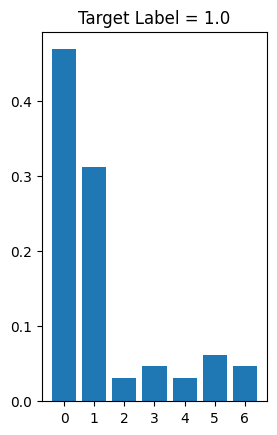

In [114]:
# In tasks 3 and 4, we addressed two different types of machine learning problems: regression and classification.
# Task 3 focused on predicting a real number, specifically the number of crime victims. We used a regression model and Mean Squared Error (MSE) loss function.
# Task 4, on the other hand, involved classifying the number of crime victims into one of seven categories. We employed a classification model with a softmax activation function and Cross Entropy loss.

# Comparing the results, the classification task (Task 4) worked better for this particular problem.
# This is likely because classifying into predefined categories can be more suitable when dealing with discrete outcomes.
# The classification model provides a clearer understanding of different victim count groups and its relationship with input features.

import matplotlib.pyplot as plt

output = model(X_test)
_, pred = torch.max(output.data, 1)

# Finding the misclassified sample.
misclassified_index = 0
for i in range(len(pred)):
    if(pred[i] != y_test[i]):
        misclassified_index = i
        break

# Plotted the bar graph for misclassified sample.
ax = plt.subplot(121)
ax.bar(range(7), output[misclassified_index].detach().numpy())
print(output[misclassified_index])
ax.set_xticks(range(7))
plt.title('Target Label = {}'.format(y_test[misclassified_index].detach().numpy()));

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


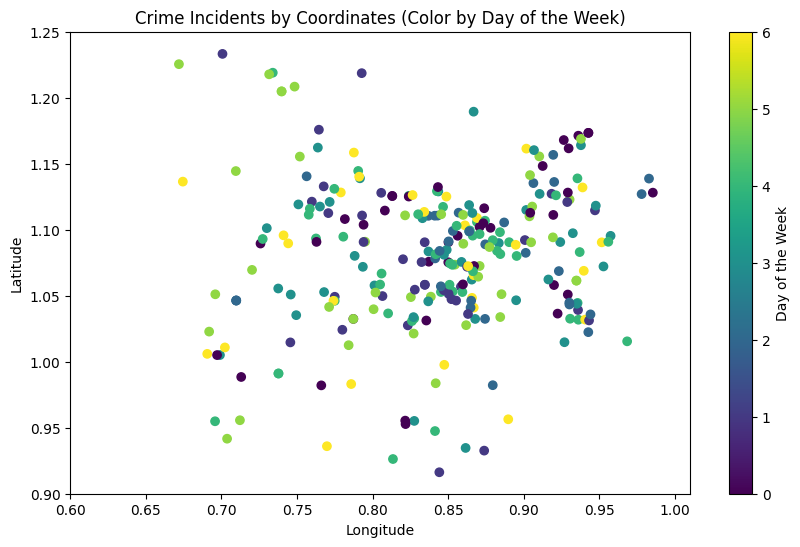

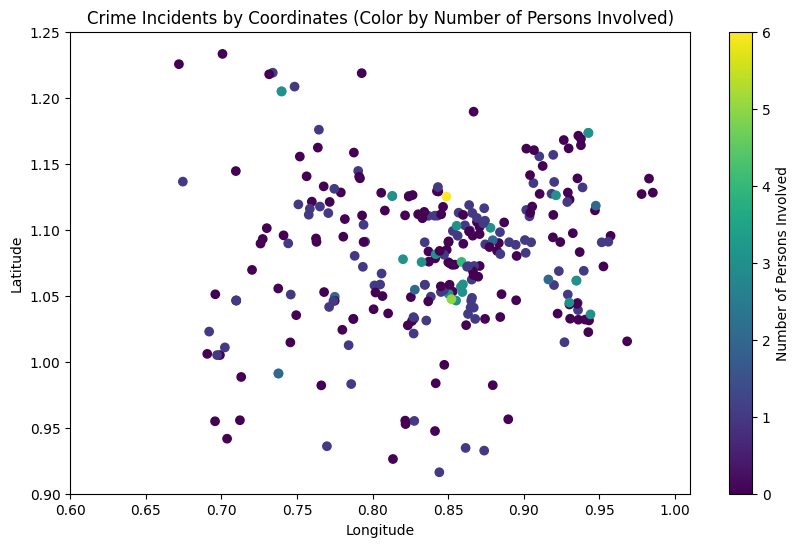


Reported crime based on the day of week:
4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: DayOfWeek, dtype: int64
4


In [115]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter plot by coordinates, color by day of the week
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c = df['DayOfWeek'], cmap='viridis')
plt.colorbar(label='Day of the Week')
plt.title('Crime Incidents by Coordinates (Color by Day of the Week)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(0.6,1.01)
plt.ylim(0.90,1.25)
plt.show()
# No pattern found in the scatter plot.

# Scatter plot by coordinates, color by number of persons involved
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c = df['VictimCount'], cmap='viridis')
plt.colorbar(label='Number of Persons Involved')
plt.title('Crime Incidents by Coordinates (Color by Number of Persons Involved)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(0.6,1.01)
plt.ylim(0.90,1.25)
plt.show()
print()
# No pattern found in the scatter plot.

# Sort number of crimes reported by day of the week
crimes_by_day = df['DayOfWeek'].value_counts()
print("Reported crime based on the day of week:")
print(crimes_by_day)

# Get the most frequent days
most_frequent_days = crimes_by_day.idxmax()
print(most_frequent_days)